In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
df = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task1/data/machine_logs.csv")
print(df.head())
print(df.info())


             timestamp       machine_id  sensor_temp_c  vibration_mm_s  \
0  2025-01-01 00:00:00  MILL_CRUSHER_01      64.168495       10.652147   
1  2025-01-01 00:05:00  MILL_CRUSHER_01      59.834133        9.566729   
2  2025-01-01 00:10:00  MILL_CRUSHER_01      59.281779       10.375491   
3  2025-01-01 00:15:00  MILL_CRUSHER_01      62.957002       10.769664   
4  2025-01-01 00:20:00  MILL_CRUSHER_01      61.440107        9.927583   

  status_code  
0     Running  
1     Running  
2     Running  
3     Running  
4     Running  
<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       100000 non-null  str    
 1   machine_id      100000 non-null  str    
 2   sensor_temp_c   95025 non-null   float64
 3   vibration_mm_s  100000 non-null  float64
 4   status_code     100000 non-null  str    
dtypes: float64(2), str(3)
memory usage

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [4]:
# Drop rows missing critical identifiers
df = df.dropna(subset=['timestamp', 'machine_id'])

In [6]:
# ===================== 2. CLEANING ===========================

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows missing critical identifiers
df = df.dropna(subset=['timestamp', 'machine_id'])

# Sort for time-series operations
df = df.sort_values(by=['machine_id', 'timestamp']).reset_index(drop=True)

# ---- Temperature Cleaning ----
df.loc[(df['sensor_temp_c'] < -20) | (df['sensor_temp_c'] > 200), 'sensor_temp_c'] = np.nan

# ---- Vibration Cleaning ----
df.loc[(df['vibration_mm_s'] < 0) | (df['vibration_mm_s'] > 100), 'vibration_mm_s'] = np.nan

# Interpolate sensor gaps per machine (time-series safe)
df['sensor_temp_c'] = df.groupby('machine_id')['sensor_temp_c'].transform(lambda x: x.interpolate(limit_direction='both'))
df['vibration_mm_s'] = df.groupby('machine_id')['vibration_mm_s'].transform(lambda x: x.interpolate(limit_direction='both'))

# Status code handling
df['status_code'] = df['status_code'].fillna("UNKNOWN").astype(str)


In [7]:
# ===================== 3. FEATURE ENGINEERING =================

window = 10  # rolling window size

df['temp_roll_mean'] = df.groupby('machine_id')['sensor_temp_c'].transform(lambda x: x.rolling(window, min_periods=1).mean())
df['vib_roll_mean'] = df.groupby('machine_id')['vibration_mm_s'].transform(lambda x: x.rolling(window, min_periods=1).mean())

df['temp_roll_std'] = df.groupby('machine_id')['sensor_temp_c'].transform(lambda x: x.rolling(window, min_periods=1).std())
df['vib_roll_std'] = df.groupby('machine_id')['vibration_mm_s'].transform(lambda x: x.rolling(window, min_periods=1).std())

print("Data after cleaning & feature engineering:")
print(df.head())


Data after cleaning & feature engineering:
            timestamp       machine_id  sensor_temp_c  vibration_mm_s  \
0 2025-01-01 00:00:00  MILL_CRUSHER_01      64.168495       10.652147   
1 2025-01-01 00:05:00  MILL_CRUSHER_01      59.834133        9.566729   
2 2025-01-01 00:10:00  MILL_CRUSHER_01      59.281779       10.375491   
3 2025-01-01 00:15:00  MILL_CRUSHER_01      62.957002       10.769664   
4 2025-01-01 00:20:00  MILL_CRUSHER_01      61.440107        9.927583   

  status_code  temp_roll_mean  vib_roll_mean  temp_roll_std  vib_roll_std  
0     Running       64.168495      10.652147            NaN           NaN  
1     Running       62.001314      10.109438       3.064857      0.767506  
2     Running       61.094803      10.198122       2.676185      0.564028  
3     Running       61.560353      10.341008       2.375203      0.541987  
4     Running       61.536303      10.258323       2.057689      0.504477  


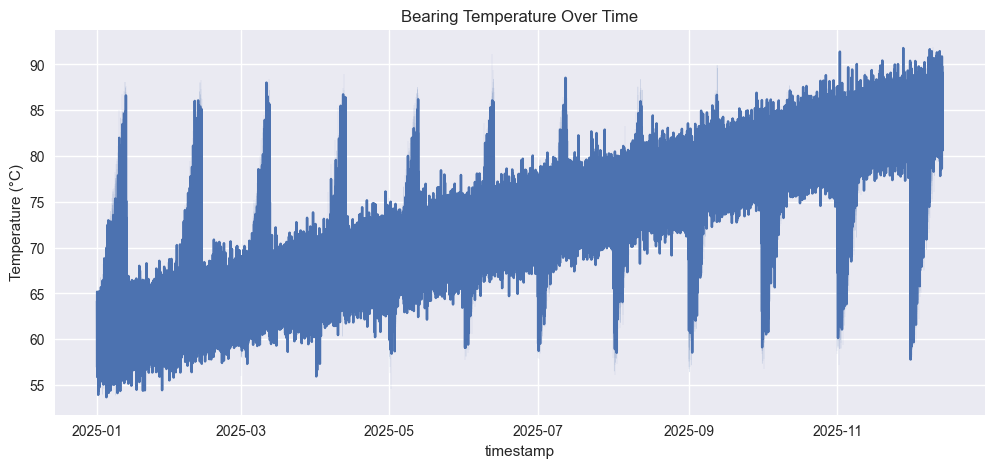

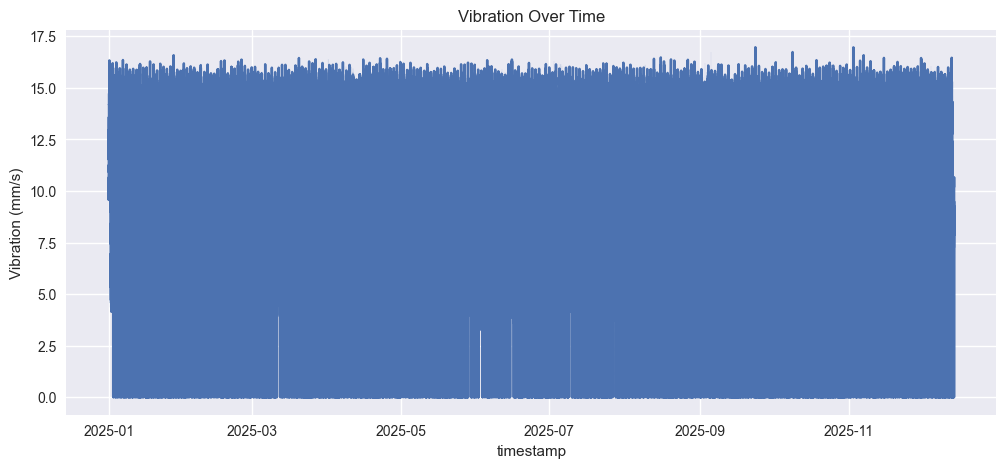

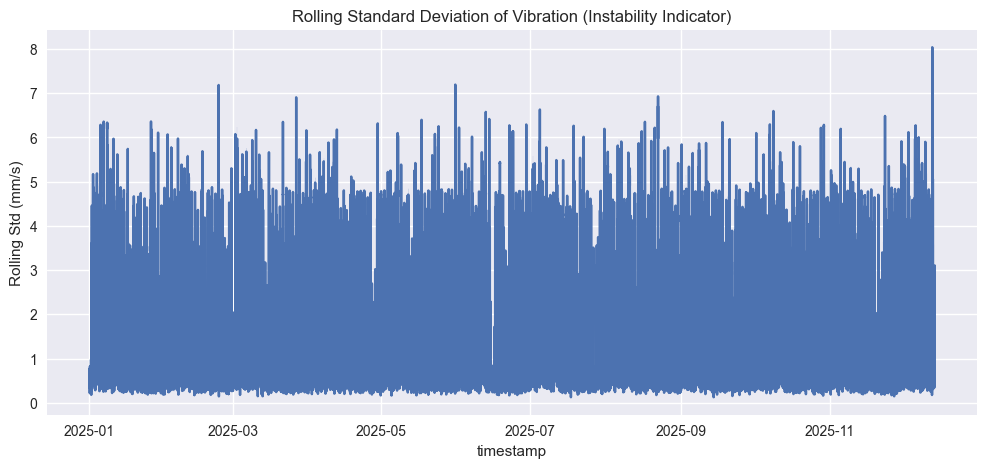

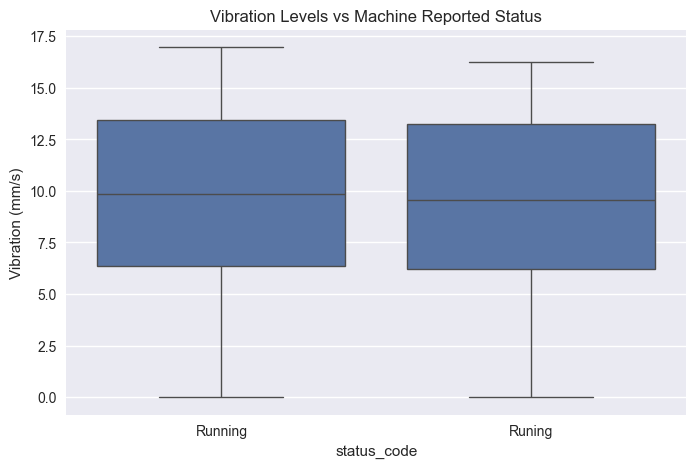


Summary Statistics:
       sensor_temp_c  vibration_mm_s  vib_roll_std
count  100000.000000   100000.000000  99999.000000
mean       72.495917        9.800146      1.372625
std         7.474631        3.802790      1.369931
min        53.670580        0.000000      0.124416
25%        66.266954        6.342047      0.481380
50%        72.508146        9.844165      0.622937
75%        78.719450       13.430006      1.992350
max        91.880099       16.969134      8.039873

If vibration rolling std increases over time while status_code remains 'OK',
this suggests hidden instability not captured by dashboard thresholds.


In [9]:
# ===================== 4. ANALYSIS PLOTS ======================

# ---- Temperature Trend ----
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='timestamp', y='sensor_temp_c', hue='machine_id', legend=False)
plt.title("Bearing Temperature Over Time")
plt.ylabel("Temperature (°C)")
plt.show()

# ---- Vibration Trend ----
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='timestamp', y='vibration_mm_s', hue='machine_id', legend=False)
plt.title("Vibration Over Time")
plt.ylabel("Vibration (mm/s)")
plt.show()

# ---- Rolling Vibration Variability (Instability Signal) ----
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x='timestamp', y='vib_roll_std', hue='machine_id', legend=False)
plt.title("Rolling Standard Deviation of Vibration (Instability Indicator)")
plt.ylabel("Rolling Std (mm/s)")
plt.show()

# ---- Dashboard Status vs Reality ----
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='status_code', y='vibration_mm_s')
plt.title("Vibration Levels vs Machine Reported Status")
plt.ylabel("Vibration (mm/s)")
plt.show()

# ===================== 5. QUICK DIAGNOSTIC ====================

print("\nSummary Statistics:")
print(df[['sensor_temp_c', 'vibration_mm_s', 'vib_roll_std']].describe())

print("\nIf vibration rolling std increases over time while status_code remains 'OK',")
print("this suggests hidden instability not captured by dashboard thresholds.")
